In [1]:
import os

import json
import string
from unidecode import unidecode
import xmltodict
import math

import imgaug
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

import keras_ocr
# commented out connectiviy=4 in line 228, detection.py

# Detection

## Dataset

In [2]:
DATASET_PATH = '../data/license-plate-dataset/dataset'  # source: https://github.com/MatiXOfficial/license-plate-dataset

In [3]:
def load_image_paths(path, n=None):
    images = []
    for file_name in os.listdir(path)[:n]:
        images.append(path + '/' + file_name)
    return np.array(images)

def _rf(a):
    return round(float(a))

def load_points(path, n=None):
    points_list = []
    for file_name in os.listdir(path)[:n]:
        with open(path + '/' + file_name) as file:
            file_data = file.read()
            dict_data = xmltodict.parse(file_data)
            object_data = dict_data['annotation']['object']
            if type(object_data) is not list: # to handle single and multiple objects
                object_data = [object_data]
                
            coords_data = [object_['bndbox'] for object_ in object_data]
            
            points = []
            for c in coords_data:
                x_min, y_min, x_max, y_max = _rf(c['xmin']), _rf(c['ymin']), _rf(c['xmax']), _rf(c['ymax'])
                if x_max - x_min >= 120:
                    p0 = [x_min, y_min]
                    p1 = [x_max, y_min]
                    p2 = [x_max, y_max]
                    p3 = [x_min, y_max]
                    points.append((np.array([p0, p1, p2, p3]), 'AB12345'))
                
            points_list.append([points])
            
    return np.array(points_list, dtype=object)

In [4]:
train_images, test_images = load_image_paths(DATASET_PATH + '/train/images'), load_image_paths(DATASET_PATH + '/valid/images')

len(train_images), len(test_images)

(425, 107)

In [5]:
train_points, test_points = load_points(DATASET_PATH + '/train/annots'), load_points(DATASET_PATH + '/valid/annots')

len(train_points), len(test_points)

(425, 107)

In [6]:
train_labels = [(filepath, points, 1) for filepath, points in zip(train_images, train_points) if points]
test_labels = [(filepath, points, 1) for filepath, points in zip(test_images, test_points) if points]

len(train_labels), len(test_labels)

(174, 60)

## Detector

In [7]:
detector = keras_ocr.detection.Detector()

Looking for C:\Users\MatiX\.keras-ocr\craft_mlt_25k.h5


## Generator

In [8]:
batch_size = 1

augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.7, 1.7)),
    imgaug.augmenters.Affine(
        scale=(0.9, 1.2),
        rotate=(-6, 6)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])

# generator_kwargs = {'width': 1280, 'height': 720}
generator_kwargs = {'width': 640, 'height': 360}

training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train_labels,
    augmenter=augmenter,
    **generator_kwargs
)
training_steps = math.ceil(len(train_labels) / batch_size)

training_gen = detector.get_batch_generator(
    image_generator=training_image_generator,
    batch_size=batch_size
)

validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=test_labels,
    **generator_kwargs
)
validation_steps = math.ceil(len(test_labels) / batch_size)

validation_gen = detector.get_batch_generator(
    image_generator=validation_image_generator,
    batch_size=batch_size
)

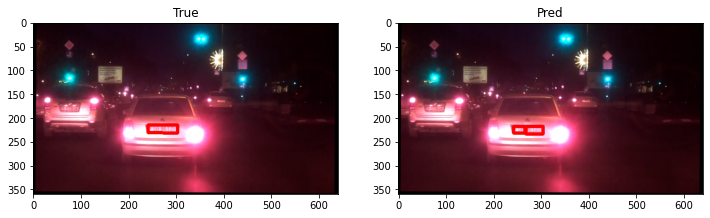

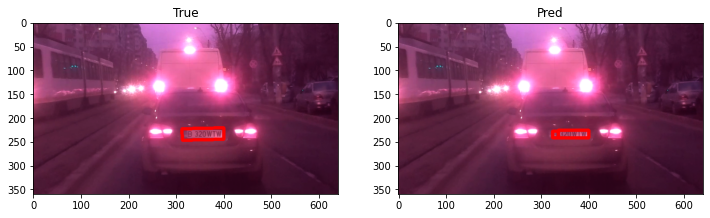

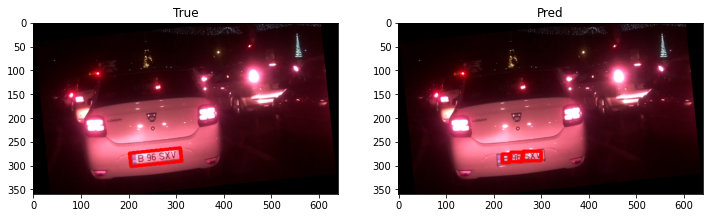

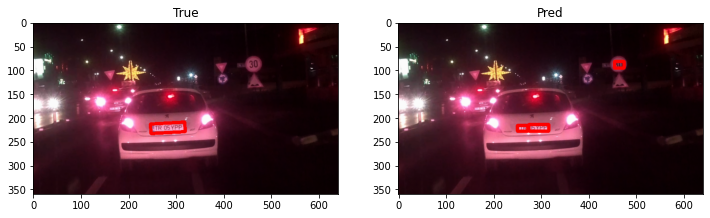

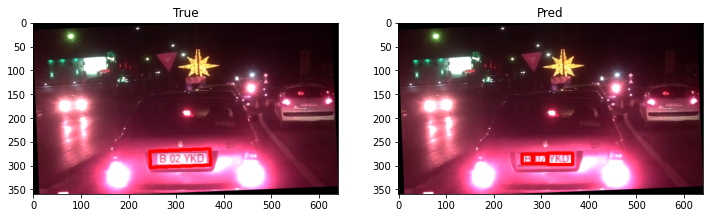

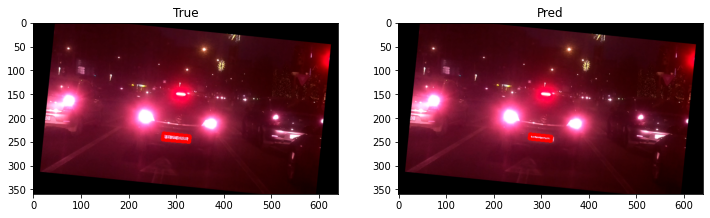

In [9]:
N = 6
test_images, test_boxes, _ = zip(*[next(training_image_generator) for _ in range(N)])

for image, boxes in zip(test_images, test_boxes):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('True')
    canvas = keras_ocr.tools.drawBoxes(image=image, boxes=boxes, boxes_format='lines')
    plt.imshow(canvas)
    
    plt.subplot(1, 2, 2)
    plt.title('Pred')
    pred_boxes = detector.detect([image])[0]
    canvas = keras_ocr.tools.drawBoxes(image=image, boxes=pred_boxes)
    plt.imshow(canvas)
    
    plt.show()

## Training

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/detector.h5', save_best_only=True),
    tf.keras.callbacks.CSVLogger('../models/detector_log.csv'),
]

detector.model.evaluate(validation_gen, steps=validation_steps)
# detector.model.fit_generator(
#     generator=training_gen,
#     steps_per_epoch=training_steps,
#     validation_steps=validation_steps,
#     validation_data=validation_gen,
#     callbacks=callbacks,
#     epochs=6
# )

detector.model.load_weights('../models/detector.h5')
detector.model.evaluate(validation_gen, steps=validation_steps)

60/60 [==============================] - 2s 37ms/step - loss: 1.6473e-04


0.00016472798597533256

## Test

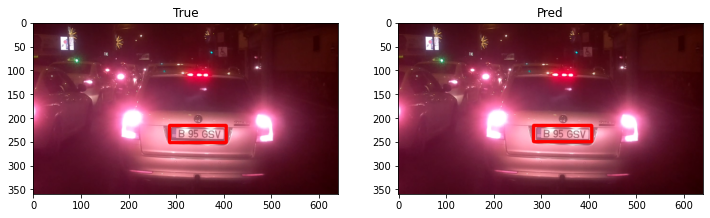

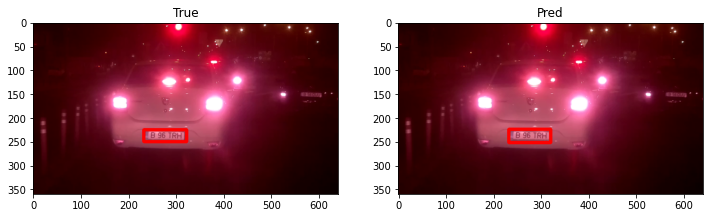

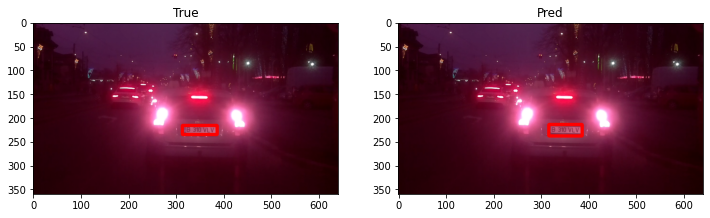

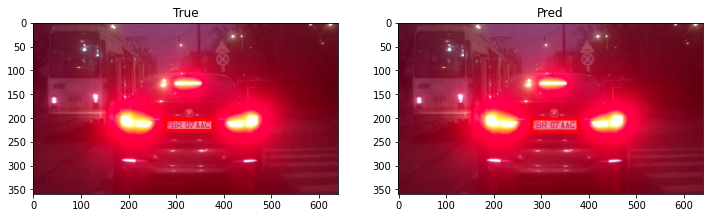

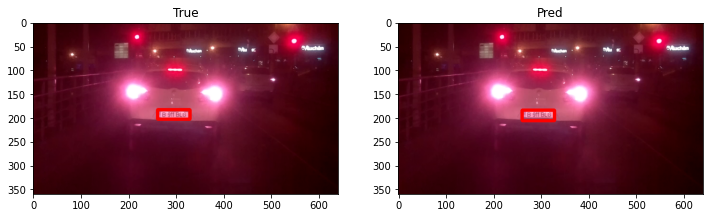

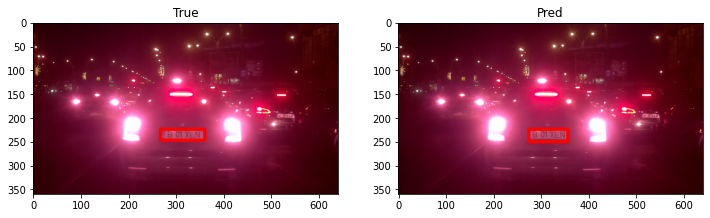

In [11]:
N = 6
test_images, test_boxes, _ = zip(*[next(validation_image_generator) for _ in range(N)])

for image, boxes in zip(test_images, test_boxes):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('True')
    canvas = keras_ocr.tools.drawBoxes(image=image, boxes=boxes, boxes_format='lines')
    plt.imshow(canvas)
    
    plt.subplot(1, 2, 2)
    plt.title('Pred')
    pred_boxes = detector.detect([image])[0]
    canvas = keras_ocr.tools.drawBoxes(image=image, boxes=pred_boxes)
    plt.imshow(canvas)
    
    plt.show()

# Recognition

## Dataset

In [12]:
DATASET_PATH = '../data/autoriaNumberplateOcrEu-2021-09-27/autoriaNumberplateOcrEu-2021-09-27'  # source: https://github.com/ria-com/nomeroff-net (EU)
N_IMAGES = 20000

In [13]:
def unidecode_file_name(path, filename):
    decoded_filename = unidecode(filename)
    if filename != decoded_filename:
        full_path = os.path.abspath(path + '/' + filename)
        decoded_filename = decoded_filename.replace(r'\\', '-')
        decoded_filename = decoded_filename.replace(r'/', '-')
        decoded_path = os.path.abspath(path + '/' + decoded_filename)
        os.rename(full_path, decoded_path)
        
for path_addon in ['/train/img', '/val/img', '/train/ann', '/val/ann']:
    path = DATASET_PATH + path_addon
    for file_name in os.listdir(path):
        unidecode_file_name(path, file_name)

In [14]:
def load_image_paths(path, n=None):
    images = []
    for file_name in os.listdir(path)[:n]:
        images.append(path + '/' + file_name)
    return np.array(images)

def load_texts(path, n=None):
    texts = []
    for file_name in os.listdir(path)[:n]:
        with open(path + '/' + file_name, encoding='utf8') as file:
            data = json.load(file)
            texts.append(data['description'])
    return np.array(texts)

In [15]:
train_images, test_images = load_image_paths(DATASET_PATH + '/train/img', N_IMAGES), load_image_paths(DATASET_PATH + '/val/img')

train_images.shape, test_images.shape

((20000,), (788,))

In [16]:
train_texts, test_texts = load_texts(DATASET_PATH + '/train/ann', N_IMAGES), load_texts(DATASET_PATH + '/val/ann')

train_texts[:4], test_texts[:4]

(array(['0005IK', 'H040077', '0010HXB', '001SCE'], dtype='<U9'),
 array(['ZH933108', '7VTG00', '7VTG00', '7U98500'], dtype='<U9'))

In [17]:
train_labels = [(filepath, None, text) for filepath, text in zip(train_images, train_texts)]
test_labels = [(filepath, None, text) for filepath, text in zip(test_images, test_texts)]

## Recognizer

In [18]:
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits + string.ascii_uppercase)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\MatiX\.keras-ocr\crnn_kurapan_notop.h5


## Generator

In [19]:
batch_size = 128

augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
    imgaug.augmenters.Affine(
        scale=(0.9, 1.02),
        rotate=(-1, 1)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 1.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])

# train
training_image_gen = keras_ocr.datasets.get_recognizer_image_generator(
    labels=train_labels,
    height=recognizer.model.input_shape[1],
    width=recognizer.model.input_shape[2],
    alphabet=string.digits + string.ascii_uppercase,
    augmenter=augmenter
)
training_steps = math.ceil(len(train_labels) / batch_size)

training_gen = recognizer.get_batch_generator(
    image_generator=training_image_gen,
    batch_size=batch_size
)

# test
validation_image_gen = keras_ocr.datasets.get_recognizer_image_generator(
    labels=test_labels,
    height=recognizer.model.input_shape[1],
    width=recognizer.model.input_shape[2],
    alphabet=string.digits + string.ascii_uppercase
)
validation_steps = math.ceil(len(test_labels) / batch_size)

validation_gen = recognizer.get_batch_generator(
    image_generator=validation_image_gen,
    batch_size=batch_size
)

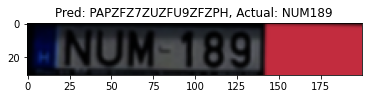

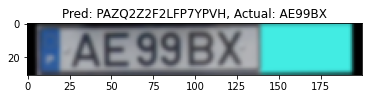

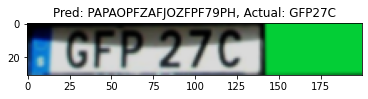

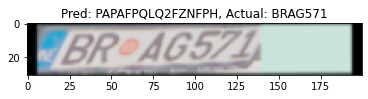

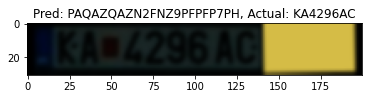

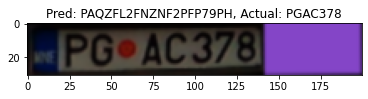

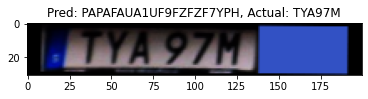

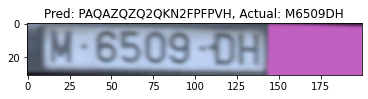

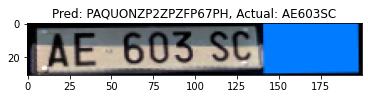

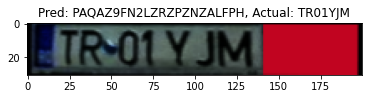

In [20]:
N = 10
test_images, test_texts = zip(*[next(training_image_gen) for _ in range(N)])

for image, text in zip(test_images, test_texts):
    pred_text = recognizer.recognize(image)

    plt.imshow(image)
    plt.title(f'Pred: {pred_text}, Actual: {text}')
    plt.show()

## Training

In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/recognizer.h5', save_best_only=True),
    tf.keras.callbacks.CSVLogger('../models/recognizer_log.csv')
]

recognizer.training_model.evaluate(validation_gen, steps=validation_steps)
# recognizer.training_model.fit_generator(
#     generator=training_gen,
#     steps_per_epoch=training_steps,
#     validation_steps=validation_steps,
#     validation_data=validation_gen,
#     callbacks=callbacks,
#     epochs=5
# )

recognizer.model.load_weights('../models/recognizer.h5')
recognizer.training_model.evaluate(validation_gen, steps=validation_steps)

7/7 [==============================] - 2s 313ms/step - loss: 0.3530


0.353008896112442

## Test

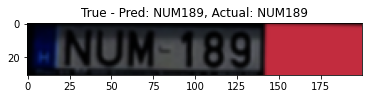

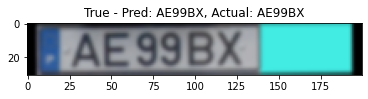

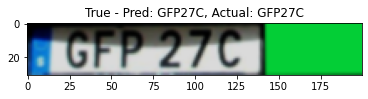

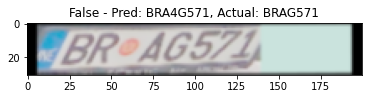

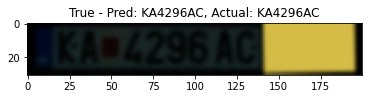

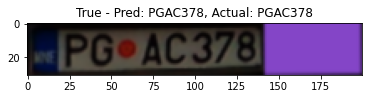

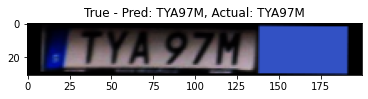

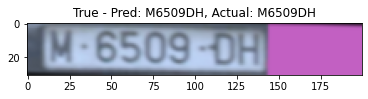

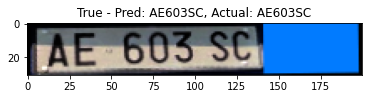

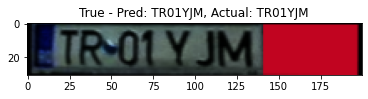

In [22]:
for image, text in zip(test_images, test_texts):
    pred_text = recognizer.recognize(image)

    plt.imshow(image)
    plt.title(f'{pred_text == text} - Pred: {pred_text}, Actual: {text}')
    plt.show()

# Parking test

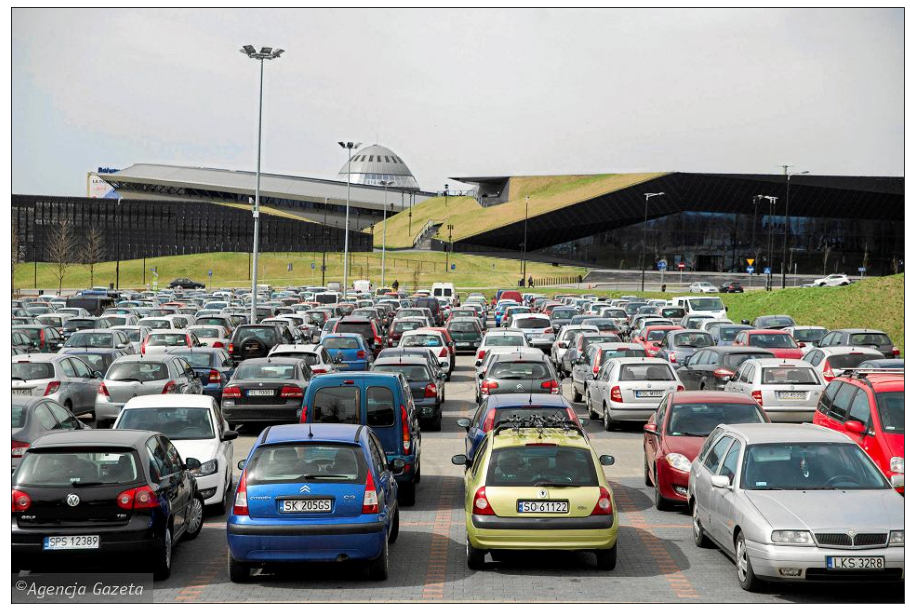

In [23]:
IMAGE_PATH_PARKING = '../data/parking.jpg'

img = keras_ocr.tools.read(IMAGE_PATH_PARKING)

plt.figure(figsize=(16, 12))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

## Default

Looking for C:\Users\MatiX\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\MatiX\.keras-ocr\crnn_kurapan.h5


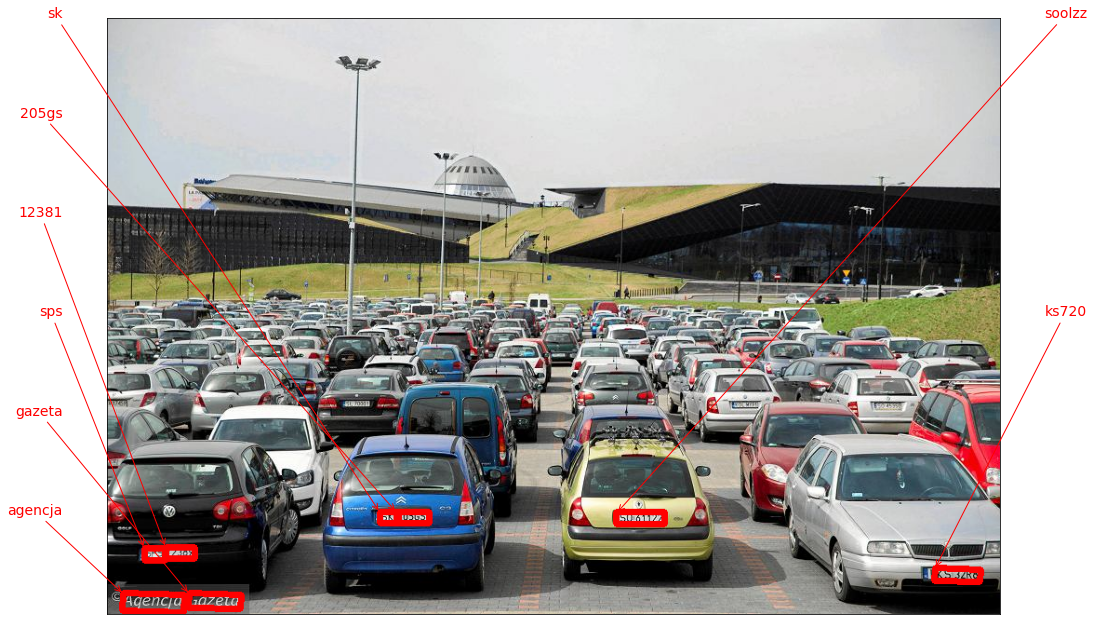

In [24]:
pipeline = keras_ocr.pipeline.Pipeline()

prediction_groups = pipeline.recognize([img])

plt.figure(figsize=(16, 12))
ax = plt.subplot(1, 1, 1)
keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0], ax=ax)
plt.show()

## Fine-tuned

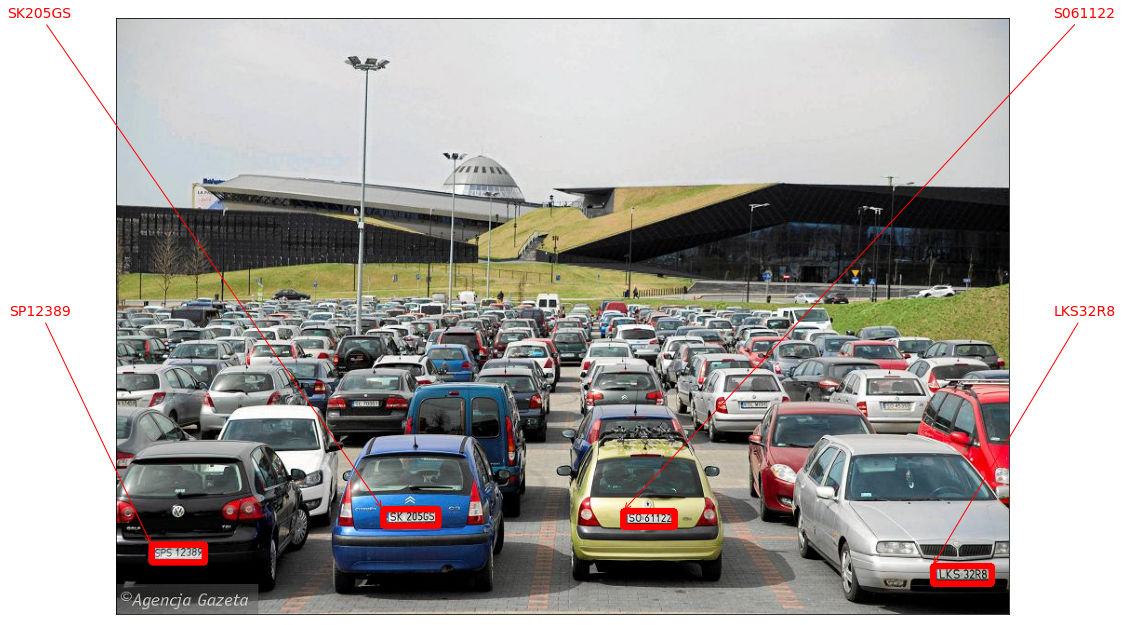

In [25]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
# pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)

img = keras_ocr.tools.read(IMAGE_PATH_PARKING)

prediction_groups = pipeline.recognize([img])

plt.figure(figsize=(16, 12))
ax = plt.subplot(1, 1, 1)
keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0], ax=ax)
plt.show()